# Tutorial - Introduction to Helmi with qiskit

Helmi is a 5 qubit Quantum Computer that is co-developed by [VTT](https://www.vttresearch.com/en/ourservices/quantum-technology) and [IQM](https://www.meetiqm.com/). It uses superconducting transmon qubits in a star shaped topology. Helmi's natives gates consist of the phased-rx and controlled-z gates. This architecture is called **Adonis** by IQM.

In this tutorial running on Helmi is demonstrated using the Qiskit framework by utilising the [qiskit-on-iqm](https://github.com/iqm-finland/qiskit-on-iqm) adapter. You can also run on Helmi using [Cirq](https://quantumai.google/cirq) with [cirq-on-iqm](https://github.com/iqm-finland/cirq-on-iqm) adapter. These notebooks are intended to be run on [`notebooks.csc.fi`](https://notebooks.rahtiapp.fi/welcome) which has access to run on Helmi. Additional documentation for notebooks.csc.fi can be found [here](https://docs.csc.fi/cloud/csc_notebooks/).

Here is Helmi! It is located in Espoo, Finland.

<img src="img/large_helmi.png" alt="VTT Helmi" width="900" height="500" class="blog-image">

## **Setup**

This notebook uses the following requirements. 

```text
qiskit-iqm==10.10
iqm-client==13.2
qiskit[visualization]
PennyLane-qiskit @ git+https://github.com/NordIQuEst/pennylane-qiskit@support-num-qubits
```

## **Using Helmi with Qiskit**

First we import [qiskit-on-iqm](https://github.com/iqm-finland/qiskit-on-iqm/tree/9.0) which is needed to run on Helmi with qiskit. You can read the user guide [here](https://iqm-finland.github.io/qiskit-on-iqm/versions/9.0/index.html).

In [1]:
import matplotlib.pyplot as plt
from qiskit_iqm import IQMProvider
import networkx as nx
from qiskit import QuantumCircuit, QuantumRegister, execute, transpile
from qiskit.tools.monitor import job_monitor
from qiskit.visualization import plot_histogram

Then connection to the backend is simple! For this we point the `IQMProvider` at what is called the "cocos URL". The cocos url to access Helmi is provided below. 

In [2]:
provider = IQMProvider("https://qc.vtt.fi/cocos")
backend = provider.get_backend()

Now that we have the backend connected to Helmi, let's print out some information about Helmi!

In [3]:
print(f'Native operations: {backend.operation_names}')
print(f'Number of qubits: {backend.num_qubits}')
print(f'Coupling map: {backend.coupling_map}')

Native operations: ['r', 'id', 'cz', 'measure']
Number of qubits: 5
Coupling map: [[0, 2], [2, 0], [1, 2], [2, 1], [2, 3], [3, 2], [2, 4], [4, 2]]


We see that the native operations on Helmi are the `r` gate and the `cz` gate. In reality Helmi has native gates `phased-rx` and `cz` and here it is given in the context of Qiskit as Qiskit does not have the PRX operation. You will see when running circuits on Helmi multiple `r` gates are quite common. These represent PRX gates with the following relation:

The phased-rx (PRX) gate is an x-rotation conjugated by a z-rotation. It can be represented as a function of  angle $\theta$ and phase $\phi$ in the computational basis with:

$$R(\theta, \phi) = e^{-i (X \cos \phi + Y \sin \phi) \: \theta/2} = R_z(\phi) R_x(\theta) R_z^\dagger(\phi)$$

Where $X$ and $Y$ are the Pauli matrices. Note that `id` gates are dropped when submitted to Helmi and Helmi does not currently allow for mid-circuit measurements. 

The topology can be visualised with `networkx`:

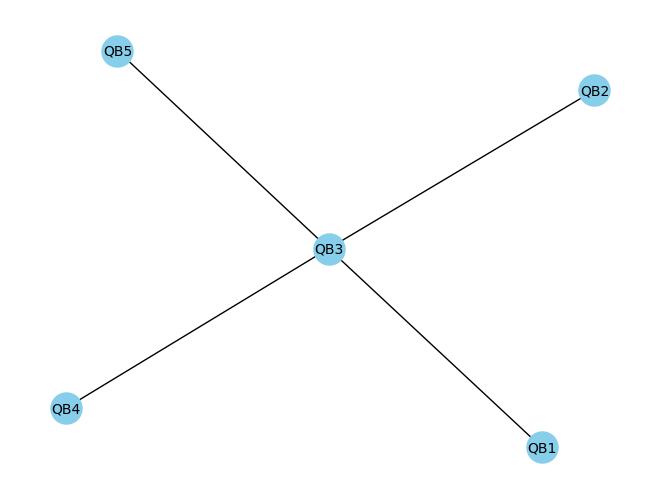

In [4]:
G = nx.Graph()
G.add_edges_from(backend.coupling_map)
node_labels = {node: f"QB{node + 1}" for node in G.nodes}
nx.draw(G, labels=node_labels, node_color='skyblue', node_size=500, font_size=10)

The topology can also be displayed as an image

<img src="img/helmi-topology.png" alt="Helmi topology" class="blog-image">

### **Constructing and executing quantum circuits**

Circuits are constructed and submitted to Helmi using the same methods as with IBM machines. First we construct a Bell pair circuit between 2 qubits. The circuit is then executed on the backend using the `execute` function.  

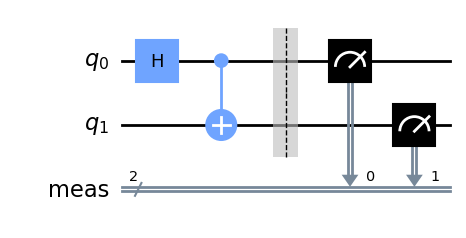

In [5]:
circuit = QuantumCircuit(2, name='Bell pair circuit')
circuit.h(0)
circuit.cx(0, 1)
circuit.measure_all()
circuit.draw(output='mpl')

### **Executing the circuit on Helmi**

When submitting a job to Helmi a unique identifier for your job is returned. This can be used to gather additional information about the circuit you just submitted and the results. **You should save your job ids!**

In [6]:
job = execute(circuit, backend, shots=100)
print(f"Job ID: {job.job_id()}.")
print("Tracking execution of job:")
job_monitor(job)

Job ID: 9e2ac0bf-900a-4028-b85f-c3330b37abb3.
Tracking execution of job:
Job Status: job has successfully run


After submitting, the job is now running. The status of the job can be queried using `job.status()`. Using the job id, you can retrieve previous jobs. 

In [7]:
status = job.status()
print(status)
#old_job = backend.retrieve_job(job_id)

JobStatus.DONE


### **Explicit Transpilation**

Instead of using the `execute` function you can also be explicit about your transpilation. 

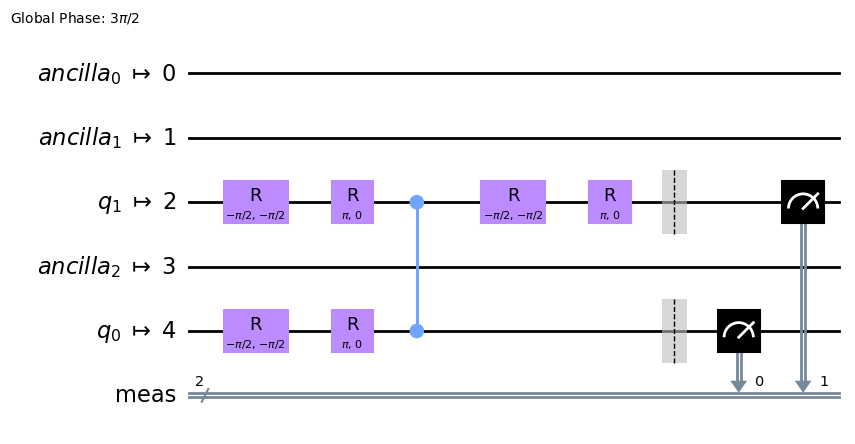

In [8]:
transpiled_circuit = transpile(circuit, backend=backend, layout_method='sabre', optimization_level=3)
transpiled_circuit.draw('mpl')

For the more control, you can also specify the initial layout in both `transpile` and `execute`. For example, Helmi's topology only allows 2 qubit gates between the central and outer qubits. Therefore we can map the 2 qubit gate to QB3.  For this we make use of the `QuantumRegister`. 

In [9]:
qreg = QuantumRegister(2, "QB")
circuit = QuantumCircuit(qreg, name='Bell pair circuit')
circuit.h(qreg[0])
circuit.cx(qreg[0], qreg[1])
circuit.measure_all()


# Qubit numbers start at 0 index whereas the qubit names start at 1 index. 
qubit_mapping = {
    qreg[0]: 0,  # Map the first qubit to QB1
    qreg[1]: 2,  # Map the second qubit to QB3
    }


job = execute(circuit, backend, shots=100, initial_layout=qubit_mapping)

 Qiskit refers to qubits using integer indices, whereas IQM uses strings. The backend class provides utility methods for mapping them to one another. Let's see on which physical qubits the logical circuit qubits were mapped.

In [10]:
mapping = {}
for qubit in circuit.qubits:
    index = circuit.find_bit(qubit).index
    mapping[index] = backend.index_to_qubit_name(index)
 
print(mapping)

{0: 'QB1', 1: 'QB2'}


### **Results**

Results can be printed once the job has completed. If results are queried before the job has completed then an error will be returned. 

67ffad7d-abd0-466a-ab93-522f8ee8d5b5
{'00': 53, '11': 41, '10': 5, '01': 1}


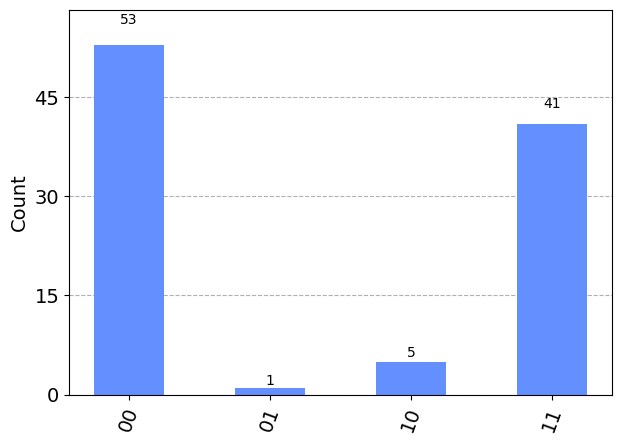

In [11]:
result = job.result()
print(result.job_id)  # The job id can be queried from the result
print(result.get_counts())
#print(result.get_memory())

plot_histogram(result.get_counts())

Additional metadata about the executed job can also be found.

In [12]:
exp_result = result._get_experiment(circuit)
print("Job ID: ", job.job_id())  # Retrieving the submitted job id
print(result.request.circuits)  # Retrieving the circuit request sent
print("Calibration Set ID: ", exp_result.calibration_set_id)  # Retrieving the current calibration set id. 
print(result.request.qubit_mapping)  # Retrieving the qubit mapping
print(result.request.shots)  # Retrieving the number of requested shots. 
print(exp_result.header)

Job ID:  67ffad7d-abd0-466a-ab93-522f8ee8d5b5
[Circuit(name='Bell pair circuit', instructions=(Instruction(name='phased_rx', implementation=None, qubits=('0',), args={'angle_t': -0.24999999999999997, 'phase_t': -0.25}), Instruction(name='phased_rx', implementation=None, qubits=('0',), args={'angle_t': 0.5, 'phase_t': 0.0}), Instruction(name='phased_rx', implementation=None, qubits=('2',), args={'angle_t': -0.24999999999999997, 'phase_t': -0.25}), Instruction(name='phased_rx', implementation=None, qubits=('2',), args={'angle_t': 0.5, 'phase_t': 0.0}), Instruction(name='cz', implementation=None, qubits=('0', '2'), args={}), Instruction(name='phased_rx', implementation=None, qubits=('2',), args={'angle_t': -0.24999999999999997, 'phase_t': -0.25}), Instruction(name='phased_rx', implementation=None, qubits=('2',), args={'angle_t': 0.5, 'phase_t': 0.0}), Instruction(name='barrier', implementation=None, qubits=('0', '2'), args={}), Instruction(name='measurement', implementation=None, qubits=(

### **Simulating circuits locally with noise**

[Qiskit on IQM](https://iqm-finland.github.io/qiskit-on-iqm/user_guide.html#noisy-simulation-of-quantum-circuit-execution) provides an `IQMFakeBackend` with `IQMFakeAdonis` for simulating Helmi. 

In [13]:
from qiskit_iqm import IQMFakeAdonis
fake_backend = IQMFakeAdonis()
job = execute(circuit, fake_backend, shots=1000)
job.result().get_counts()

{'10': 47, '00': 434, '11': 462, '01': 57}

The error profile of the noise can be queried, for example:

In [14]:
print(fake_backend.error_profile)

IQMErrorProfile(t1s={'QB1': 27000.0, 'QB2': 33000.0, 'QB3': 25000.0, 'QB4': 40000.0, 'QB5': 25000.0}, t2s={'QB1': 20000.0, 'QB2': 26000.0, 'QB3': 23000.0, 'QB4': 26000.0, 'QB5': 7000.0}, single_qubit_gate_depolarizing_error_parameters={'phased_rx': {'QB1': 0.0006, 'QB2': 0.0054, 'QB3': 0.0001, 'QB4': 0.0, 'QB5': 0.0005}}, two_qubit_gate_depolarizing_error_parameters={'cz': {('QB1', 'QB3'): 0.0335, ('QB2', 'QB3'): 0.0344, ('QB3', 'QB4'): 0.0192, ('QB3', 'QB5'): 0.0373}}, single_qubit_gate_durations={'phased_rx': 40.0}, two_qubit_gate_durations={'cz': 80.0}, readout_errors={'QB1': {'0': 0.021, '1': 0.021}, 'QB2': {'0': 0.018, '1': 0.018}, 'QB3': {'0': 0.056, '1': 0.056}, 'QB4': {'0': 0.021, '1': 0.021}, 'QB5': {'0': 0.023, '1': 0.023}}, name='sample-chip')


And the noise model can be updated. Let's give it some parameters to make the noise model more accurate.

In [15]:
error_profile = fake_backend.error_profile
error_profile.t1s['QB1'] = 38940.0  # in ns
error_profile.t1s['QB3'] = 43322.0  # in ns

error_profile.t2s['QB1'] = 24785.0  # in ns
error_profile.t2s['QB3'] = 10050.0  # in ns

error_profile.single_qubit_gate_depolarizing_error_parameters['phased_rx']['QB1'] = 0.0043 
error_profile.single_qubit_gate_depolarizing_error_parameters['phased_rx']['QB3'] = 0.0022 

error_profile.two_qubit_gate_depolarizing_error_parameters['cz'][('QB1', 'QB3')] = 0.018

error_profile.single_qubit_gate_durations['phased_rx'] = 120  # in ns
error_profile.two_qubit_gate_durations['cz'] = 120  # in ns

error_profile.readout_errors['QB1']['0'] = 0.03375
error_profile.readout_errors['QB1']['1'] = 0.03865
error_profile.readout_errors['QB3']['0'] = 0.0365
error_profile.readout_errors['QB3']['1'] = 0.05885

error_profile.name = 'fake_helmi'


helmi_fake_backend = fake_backend.copy_with_error_profile(error_profile)

Let's test to see how accurate our noise model is!

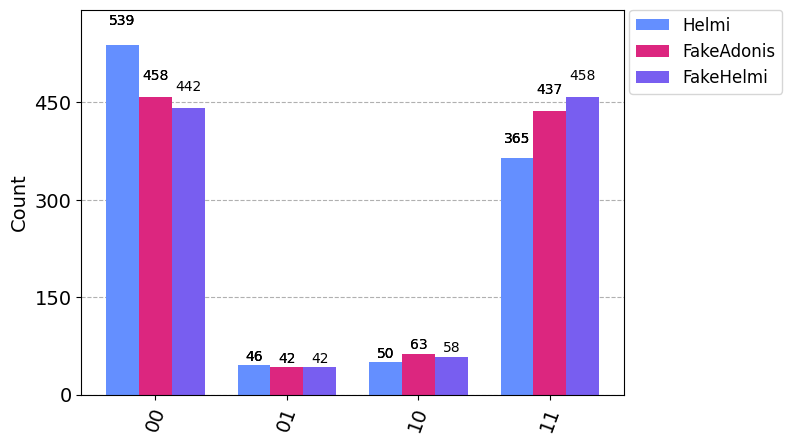

In [16]:
job_1 = execute(circuit, backend, shots=1000)
job_2 = execute(circuit, fake_backend, shots=1000)
job_3 = execute(circuit, helmi_fake_backend, shots=1000)

counts_1 = job_1.result().get_counts()
counts_2 = job_2.result().get_counts()
counts_3 = job_3.result().get_counts()

legend = ["Helmi", "FakeAdonis", "FakeHelmi"]
plot_histogram([counts_1, counts_2, counts_3], legend=legend)

### **Batch execution**

Helmi also allows for batches of circuits to be submitted with 1 call to the quantum computer. A batch is simply a list of `QuantumCircuits`. This is often faster than executing circuits individually, however, circuits will still be executed sequentially. On Helmi currently you can only place a maximum of 20 circuits in one batch. All circuits in a batch are executed with the same number of shots. The maximum number of shots per circuit is 100,000. 

A batch of circuits has an additional restriction that all circuits in the batch must measure the same qubits. In this case, batch execution is useful for parameterized circuits to be executed using the [`qiskit.circuit.Parameter`](https://qiskit.org/documentation/stubs/qiskit.circuit.Parameter.html) class. 

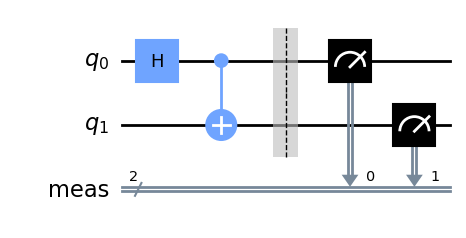

In [17]:
circuits_list = []

circuit_1 = QuantumCircuit(2, name='Bell pair circuit')
circuit_1.h(0)
circuit_1.cx(0, 1)
circuit_1.measure_all()
circuits_list.append(circuit_1)

circuit_1.draw(output='mpl')

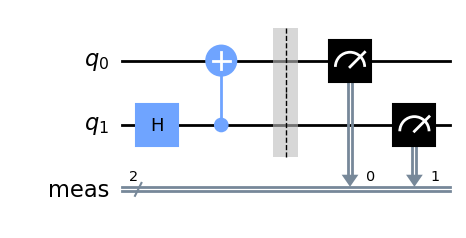

In [18]:
circuit_2 = QuantumCircuit(2, name='Reverse Bell pair circuit')
circuit_2.h(1)
circuit_2.cx(1, 0)
circuit_2.measure_all()
circuits_list.append(circuit_2)

circuit_2.draw(output='mpl')

In [19]:
# Execute and monitor job
job = execute(circuits_list, backend, shots=10, optimization_level=0, initial_layout=[0, 2])
print("Tracking execution of job:")
job_monitor(job)

Tracking execution of job:
Job Status: job has successfully run


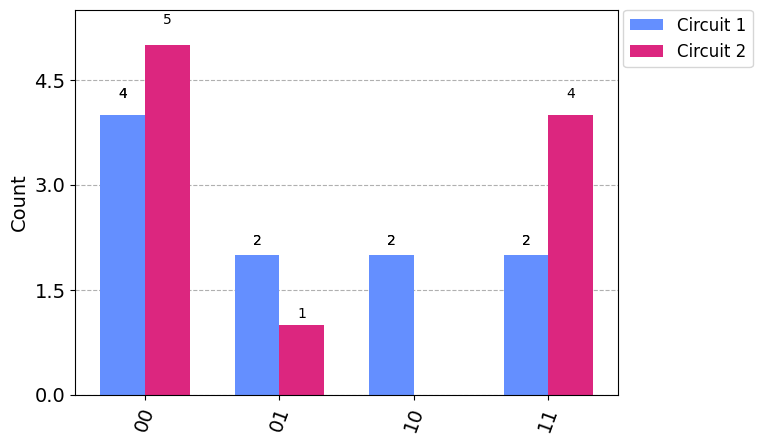

In [20]:
# Get results
result = job.result()

# Plot histograms
plot_histogram(result.get_counts(), legend=['Circuit 1', 'Circuit 2'])

## **[Pennylane Qiskit](https://docs.pennylane.ai/projects/qiskit/en/latest/)**

You can also run Pennylane code on Helmi with the [PennyLane-Qiskit Plugin](https://docs.pennylane.ai/projects/qiskit/en/latest/). The `IQMBackend` object uses `BackendV2` currently which Pennylane-Qiskit does not support, therefore we use a [forked-version](https://github.com/JMuff22/pennylane-qiskit/tree/support-num-qubits) that fixes this. 

In [21]:
import pennylane as qml

provider = IQMProvider("https://qc.vtt.fi/cocos")
backend = provider.get_backend()


dev = qml.device('qiskit.remote', wires=5, backend=backend, shots=10)

print(dev.capabilities())

@qml.qnode(dev, interface="autograd")
def circuit(params):
    qml.RX(params[0], wires=0)
    qml.RY(params[1], wires=0)
    return qml.expval(qml.PauliZ(0))


print(circuit([0.54, 0.12]))

{'model': 'qubit', 'tensor_observables': True, 'inverse_operations': True, 'returns_state': False, 'supports_broadcasting': False, 'supports_finite_shots': True, 'supports_tensor_observables': True, 'returns_probs': True}
1.0


## **Summary**

In this notebook we have demonstrated how to connect and run circuits on Helmi with Qiskit, qiskit-on-iqm and the PennyLane-Qiskit plugin. You are encouraged to use Helmi and apply what you have learnt to the exercise from day 1! Below are some tasks!

## **Tasks**

Here are some tasks to demonstrate usage of Helmi and how to improve the results. Do you notice any differences compared to when you run with the simulator? 

### **Task 1**

In this task we create an entangled state on a real quantum computer! This follows [the second practice session from yesterday](https://enccs.github.io/nordiquest-workshop/notebooks/E1_qc-2/#multi-qubit-gates).

Here is a demonstration of creating a Bell pair (Entanglement!) between qubits 1 and 3. Create an entanglement between the other qubit pairs according to the topology of Helmi! Which are the best qubit pairs today?


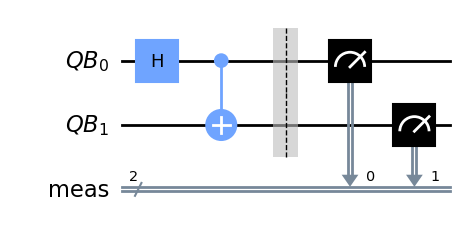

In [22]:
# create quantum circuit
qreg = QuantumRegister(2, "QB")
qc = QuantumCircuit(qreg, name='Bell pair circuit')

qc.h(0)
qc.cx(0, 1)
qc.measure_all()

qc.draw('mpl')

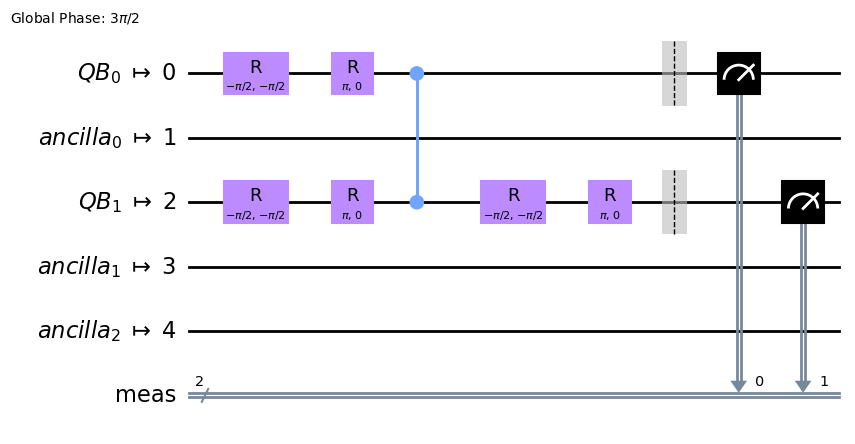

In [23]:
# Transpile the circuit 

qubit_mapping = {
    qreg[0]: 0,  # Map the first qubit to QB1
    qreg[1]: 2,  # Map the second qubit to QB3
}
transpiled_circuit = transpile(qc, backend=backend, initial_layout=qubit_mapping)
transpiled_circuit.draw('mpl')

Job Status: job has successfully run
{'00': 488, '11': 474, '10': 40, '01': 22}


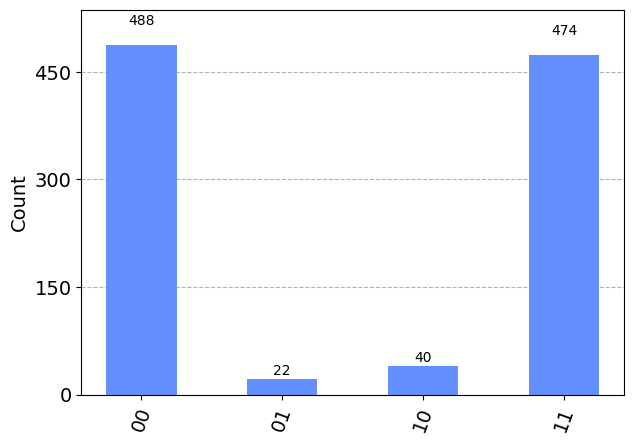

In [24]:
# Execute the circuit

job = backend.run(transpiled_circuit)

job_monitor(job)
counts = job.result().get_counts()
print(counts)

plot_histogram(counts)

#### **Task 1 - Solution**

In [25]:
def create_bell_pair_circuit(outer_qubit):
    """For a given outer qubit, create a bell pair between the outer qubit and QB3"""
    qreg = QuantumRegister(2, "QB")
    qc = QuantumCircuit(qreg, name='Bell pair circuit')
    qc.h(0)
    qc.cx(0, 1)
    qc.measure_all()
    
    # Create the qubit mapping
    qubit_mapping = {
        qreg[0]: outer_qubit,
        qreg[1]: 2,  # Map the second qubit to QB3
    }
    
    # Transpile the circuit with the qubit mapping
    transpiled_circuit = transpile(qc, backend=backend,  initial_layout=qubit_mapping)
    
    return transpiled_circuit

outer_qubits = [0, 1, 3, 4]  # Qubits 1, 2, 4, 5
bell_pair_circuits = [create_bell_pair_circuit(q) for q in outer_qubits]

# uncomment to draw the circuits
# for circuit in bell_pair_circuits:
#     display(circuit.draw('mpl'))

jobs = [execute(qc, backend, shots=100) for qc in bell_pair_circuits]

for i, job in enumerate(jobs):
    job_monitor(job)
    counts = job.result().get_counts()
    print(f"Counts for outer qubit {outer_qubits[i]}: {counts}")

Job Status: job has successfully run
Counts for outer qubit 0: {'11': 45, '00': 52, '01': 2, '10': 1}
Job Status: job has successfully run
Counts for outer qubit 1: {'00': 52, '11': 39, '10': 7, '01': 2}
Job Status: job has successfully run
Counts for outer qubit 3: {'10': 8, '11': 34, '01': 4, '00': 54}
Job Status: job has successfully run
Counts for outer qubit 4: {'00': 48, '11': 45, '01': 2, '10': 5}


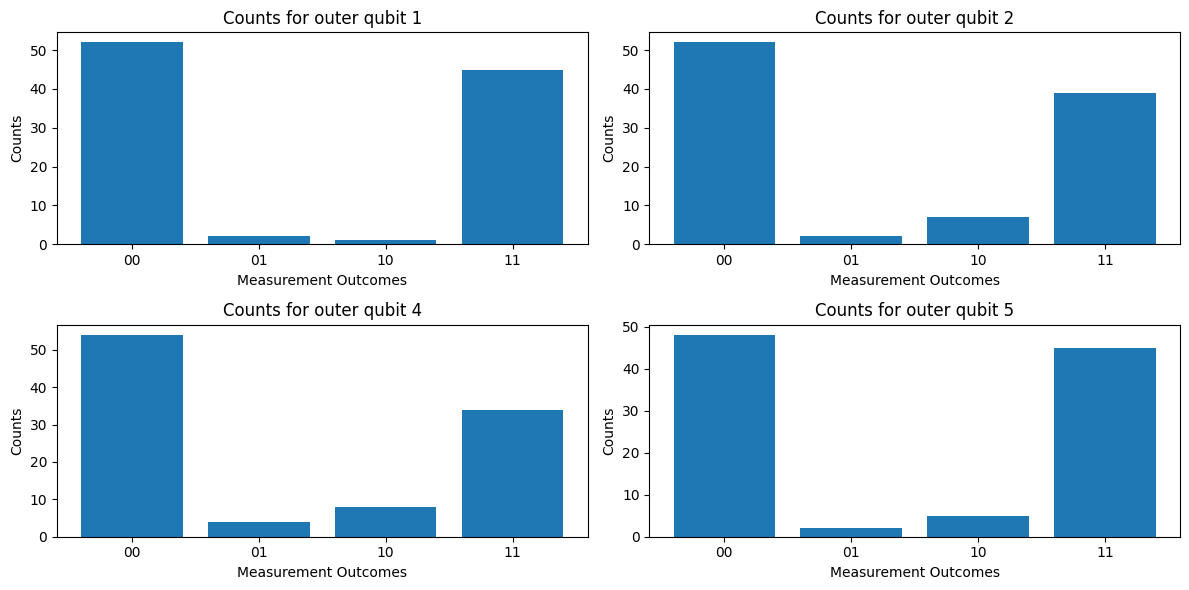

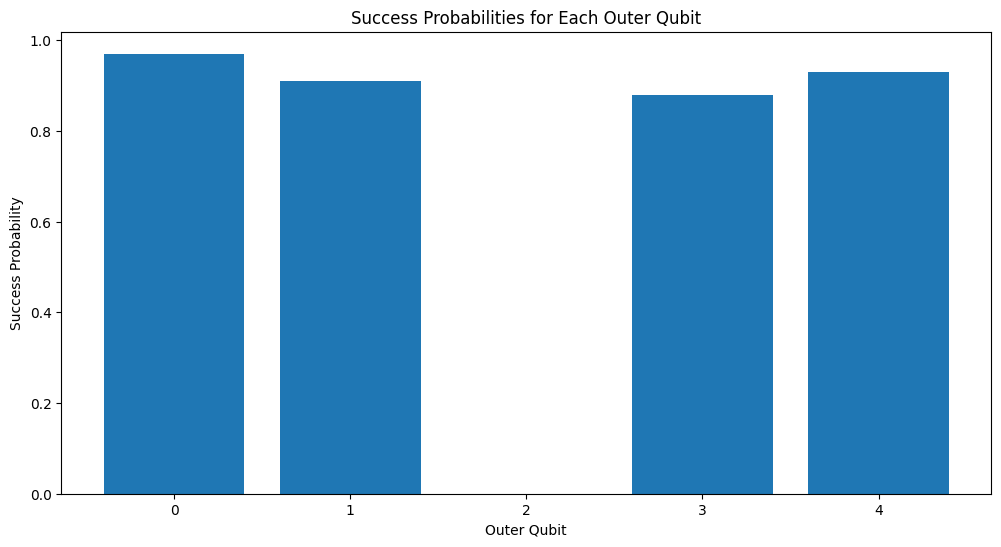

In [26]:

def success_probability(counts):
    total_shots = sum(counts.values())
    success_count = counts.get('00', 0) + counts.get('11', 0)
    return success_count / total_shots

outcome_order = ['00', '01', '10', '11']
success_probabilities = [success_probability(counts) for counts in [job.result().get_counts() for job in jobs]]


# Plot histograms for counts
plt.figure(figsize=(12, 6))

for i, counts in enumerate([job.result().get_counts() for job in jobs]):
    plt.subplot(2, 2, i + 1)
    sorted_counts = {outcome: counts.get(outcome, 0) for outcome in outcome_order}
    plt.bar(sorted_counts.keys(), sorted_counts.values())
    plt.title(f'Counts for outer qubit {outer_qubits[i]+1}')
    plt.xlabel('Measurement Outcomes')
    plt.ylabel('Counts')

plt.tight_layout()

# Plot histograms for success probabilities
plt.figure(figsize=(12, 6))
plt.bar(outer_qubits, success_probabilities)
plt.title('Success Probabilities for Each Outer Qubit')
plt.xlabel('Outer Qubit')
plt.ylabel('Success Probability')

plt.show()

### **Task 2 - Entangling more qubits: GHZ**

We've now seen that we can create a Bell pair circuit where 2 qubits are entangled. What about entangling more than 2 qubits? The **Greenberger-Horne-Zeilinger** (GHZ) State does precisely this by creating an *n*-qubit entangled state. Running a GHZ experiment is useful for assessing the multi-qubit interactions in a quantum computer. 

Here we demonstrate a 5 qubit GHZ circuit on Helmi.

#### **Creating the GHZ circuit**

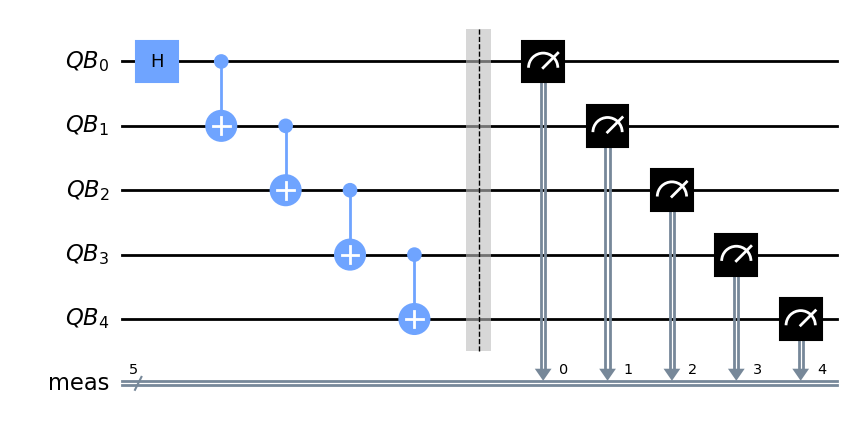

In [27]:
# create quantum circuit

shots = 1000

qreg = QuantumRegister(5, "QB")
qc = QuantumCircuit(qreg, name='GHZ circuit')

qc.h(0)
qc.cx(0, 1)                      # apply CNOT, control=0, target=1
qc.cx(1, 2)
qc.cx(2, 3)
qc.cx(3, 4)
qc.measure_all()

qc.draw('mpl')

Let's see what the simulator gives

{'11111': 494, '00000': 506}


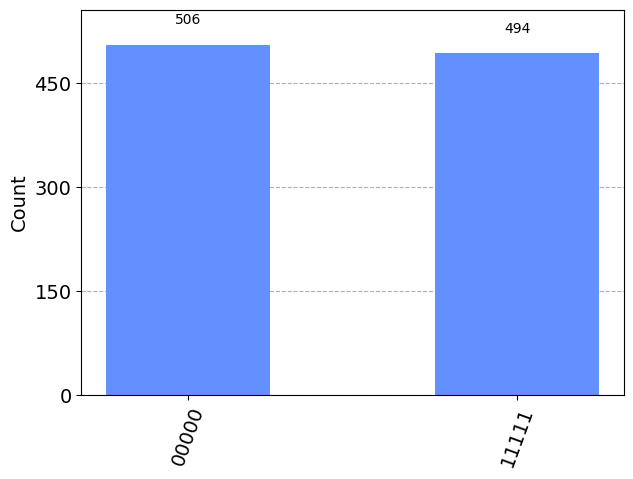

In [28]:
from qiskit import Aer

simulator = Aer.get_backend('aer_simulator')
result = simulator.run(qc, shots=shots).result()
counts = result.get_counts()   # extract statistics from results
print(counts)

plot_histogram(counts)

In this approach, the circuit is created in a 'textbook' fashion. Due to the topology of Helmi, after transpiling the circuit it becomes much longer because SWAP gates are needed. 

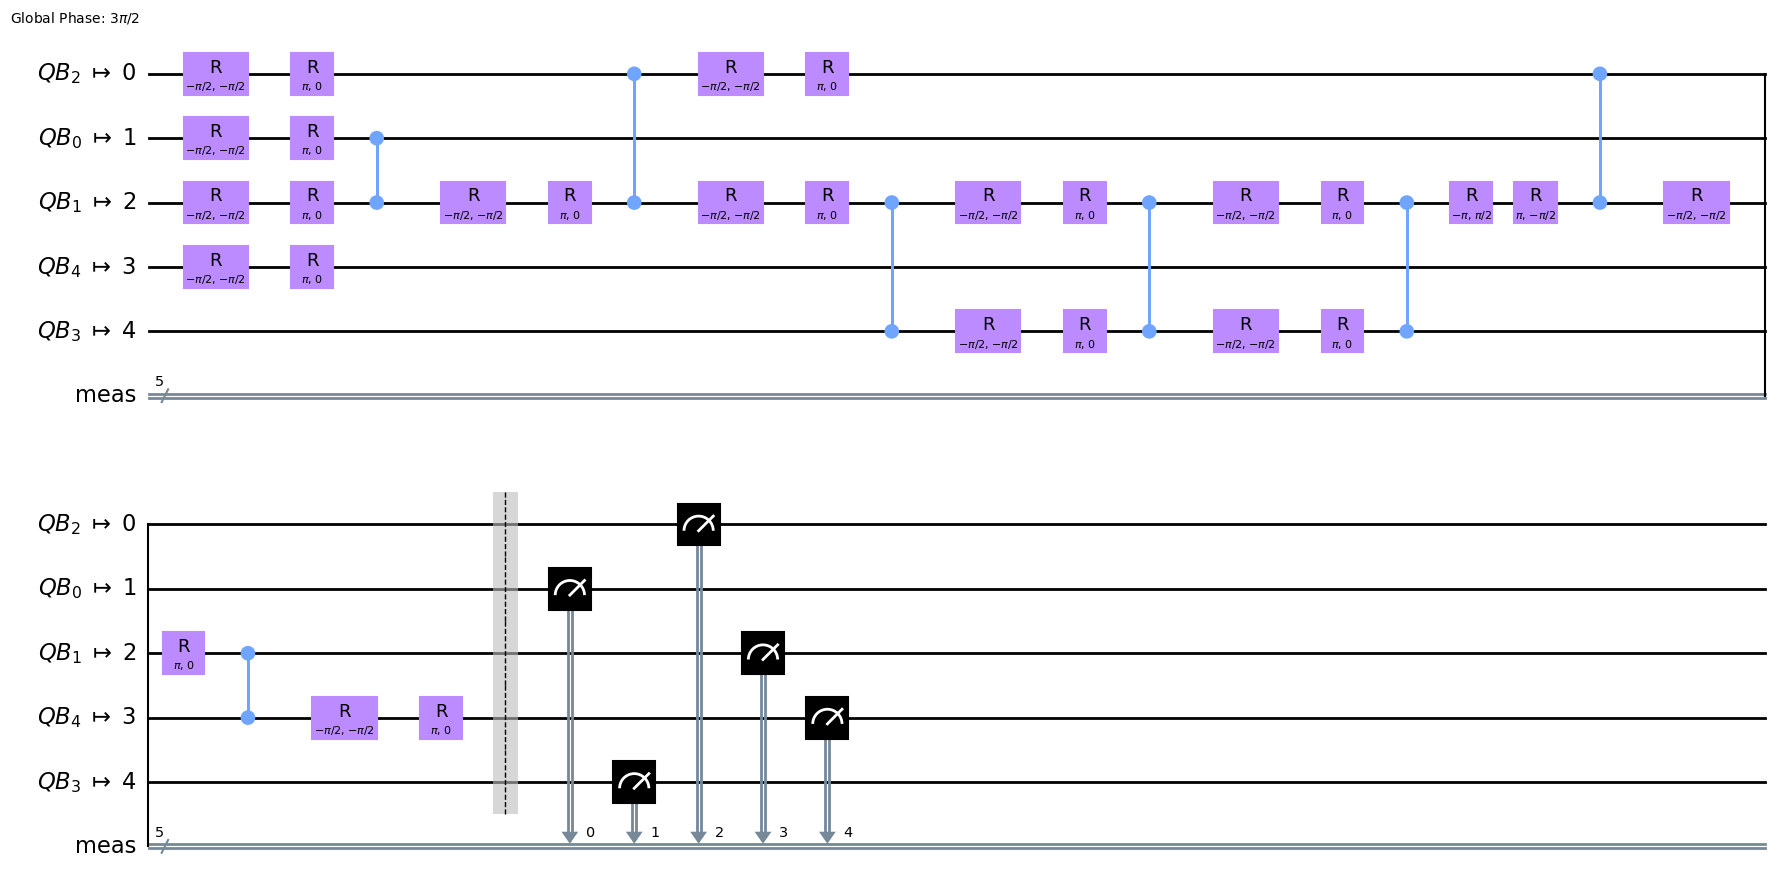

In [29]:
transpiled_circuit = transpile(qc, backend=backend, layout_method='sabre', optimization_level=3)
transpiled_circuit.draw('mpl')

This can be shown by only displaying the routed circuit, without decomposition into native gates. 

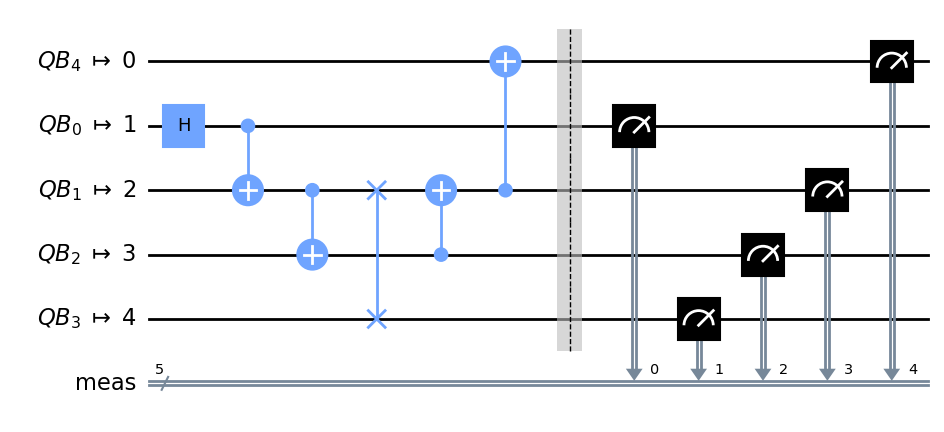

In [30]:
transpiled_circuit_simple = transpile(qc, coupling_map=backend.coupling_map, layout_method='sabre', optimization_level=3)
transpiled_circuit_simple.draw('mpl')

Let's run this on Helmi!

Job Status: job has successfully run


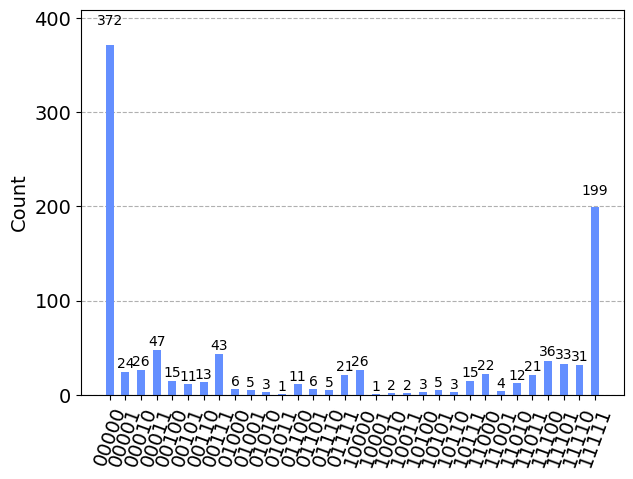

In [31]:
job = backend.run(transpiled_circuit)

job_monitor(job)
counts = job.result().get_counts()   # extract statistics from results

plot_histogram(counts)

In this case we have an additional swap gates due to the central qubit (QB3) being the only available qubit to make 2 qubit gates. 

We can reduce the number of swap gates needed and improve our GHZ 5 result by placing the Hadamard gate on the central qubit and CNOTs on all the neighbours. 

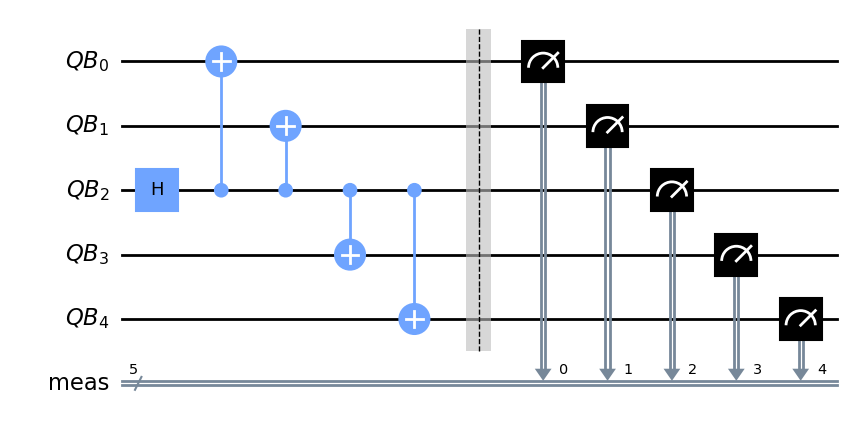

In [32]:
# create quantum circuit
qreg = QuantumRegister(5, "QB")
qc = QuantumCircuit(qreg, name='GHZ circuit')

qc.h(2)
qc.cx(2, 0)
qc.cx(2, 1)
qc.cx(2, 3)
qc.cx(2, 4)

qc.measure_all()

qc.draw('mpl')

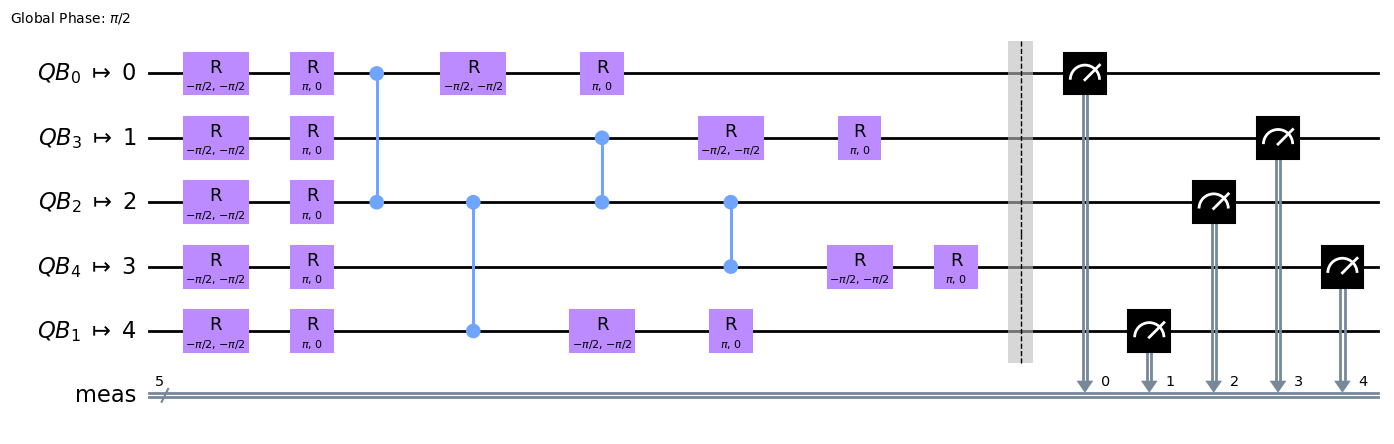

In [33]:
transpiled_circuit = transpile(qc, backend=backend, layout_method='sabre', optimization_level=3)
transpiled_circuit.draw('mpl')

Now we run the code on Helmi and look at the histogram. 

Job Status: job has successfully run


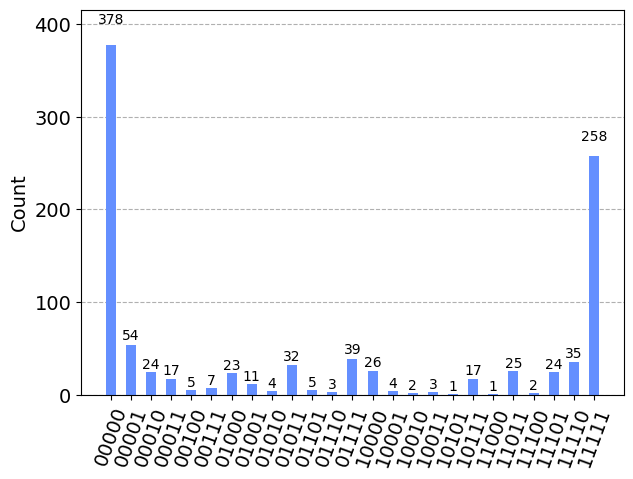

In [34]:
job = backend.run(transpiled_circuit, shots=1000)

job_monitor(job)

counts = job.result().get_counts()
plot_histogram(counts)

### **Simple readout error mitigation**

Error mitigation is a class of techniques aimed at reducing the error from submitting to the current generation of noisy devices. This exercise demonstrates how to apply simple readout error mitigation to improve the results from our GHZ circuit. 

This follows Qiskit's tutorial: [Readout Mitigation](https://qiskit.org/ecosystem/experiments/manuals/measurement/readout_mitigation.html), however alternatives such as [Mitiq](https://mitiq.readthedocs.io/en/stable/index.html) can be used. Mitiq provides an open-source library to learn about and implement error mitigation. 

For this brief example, *readout* error mitigation is applied using the [`LocalReadoutError`](https://qiskit.org/ecosystem/experiments/stubs/qiskit_experiments.library.characterization.LocalReadoutError.html#qiskit_experiments.library.characterization.LocalReadoutError) mitigator from `qiskit.experiments`. Readout error mitigation refers to errors related to "reading out" of the quantum state into classical information which occurs during measurement. 

With the [`LocalReadoutError`](https://qiskit.org/ecosystem/experiments/stubs/qiskit_experiments.library.characterization.LocalReadoutError.html#qiskit_experiments.library.characterization.LocalReadoutError), a $2^n \times 2^n$ assignment matrix $A$ is created, containing the probabilities to observe $y$, given $x$. That is to say that the individual elements of the matrix will contain the probabilities that a qubit prepared in state $|0 \rangle$ or $|1 \rangle$ and was measured in either state $|0 \rangle$ or $|1 \rangle$.

Here we demonstrate the[ `LocalReadoutMitigator`](https://qiskit.org/documentation/stubs/qiskit.result.LocalReadoutMitigator.html#qiskit.result.LocalReadoutMitigator) example, which assumes the readout errors of the qubits are uncorrelated. In this case $n 2 \times 2$  *mitigation matrices* are generated, 1 for each qubit. 

First we generate 2 circuits for all of Helmi's qubits. The first circuit has no gates applied with the ideal outcome of all zeros: `00000`, the second circuit applied an $X$ gate to our circuit with the ideal outcome of all ones: `11111`. After running the experiment we get the [Mitigator](https://qiskit.org/documentation/stubs/qiskit.result.LocalReadoutMitigator.html#qiskit.result.LocalReadoutMitigator) which returns the mitigated qasi-probabilities. 

In [35]:
from qiskit_experiments.library import LocalReadoutError

qubits = [0, 1, 2, 3, 4]

# The qiskit experiment class generates the "Calibration Circuits" based off the experiment and the qubits input. 
exp = LocalReadoutError(qubits)
for c in exp.circuits():
    print(c)

         ░ ┌─┐            
   q_0: ─░─┤M├────────────
         ░ └╥┘┌─┐         
   q_1: ─░──╫─┤M├─────────
         ░  ║ └╥┘┌─┐      
   q_2: ─░──╫──╫─┤M├──────
         ░  ║  ║ └╥┘┌─┐   
   q_3: ─░──╫──╫──╫─┤M├───
         ░  ║  ║  ║ └╥┘┌─┐
   q_4: ─░──╫──╫──╫──╫─┤M├
         ░  ║  ║  ║  ║ └╥┘
meas: 5/════╩══╩══╩══╩══╩═
            0  1  2  3  4 
        ┌───┐ ░ ┌─┐            
   q_0: ┤ X ├─░─┤M├────────────
        ├───┤ ░ └╥┘┌─┐         
   q_1: ┤ X ├─░──╫─┤M├─────────
        ├───┤ ░  ║ └╥┘┌─┐      
   q_2: ┤ X ├─░──╫──╫─┤M├──────
        ├───┤ ░  ║  ║ └╥┘┌─┐   
   q_3: ┤ X ├─░──╫──╫──╫─┤M├───
        ├───┤ ░  ║  ║  ║ └╥┘┌─┐
   q_4: ┤ X ├─░──╫──╫──╫──╫─┤M├
        └───┘ ░  ║  ║  ║  ║ └╥┘
meas: 5/═════════╩══╩══╩══╩══╩═
                 0  1  2  3  4 


The experiment can simple be run. Qiskit's experiments library takes take of the circuit transpilation and execution in addition to analysis. In this case the above circuits are run and then analysed. 

In [36]:
provider = IQMProvider("https://qc.vtt.fi/cocos")
backend = provider.get_backend()

# from qiskit import Aer
# backend = Aer.get_backend('aer_simulator')

exp.analysis.set_options(plot=True)

result = exp.run(backend)
mitigator = result.analysis_results(0).value

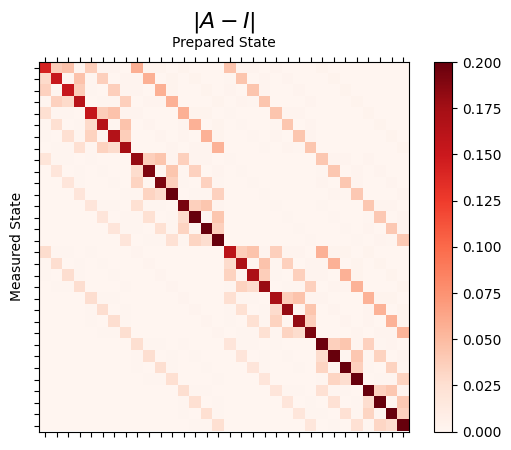

In [37]:
result.figure(0)

Here $A$ is the assignment matrix, with $I$ being the identity matrix. The individual components of the assignment matrix represent the probabilities to, for example prepare a $|0 \rangle$ state and get a $|1 \rangle$ state or $|1\rangle$ state and get a $|0\rangle$ state. This is compared against the identity matrix because in the ideal case we would expect $P(X|X) = 1$ and $P(X|Y) = 0$ ($P(X|X)$ means the probability of $X$ given $X$) The plot shows the absolute value of these two matrices. 

The automatic scale given by Qiskit experiments can be slightly misleading, as demonstrated when you run this with the simulator. 

The assignment matrix can be printed. 

In [38]:
mitigator.assignment_matrix()
print(len(mitigator.assignment_matrix()))

32


If, for example we used the simulator here the assignment matrix would look like the following:

```python
array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 1., 0., 0.],
       [0., 0., 0., ..., 0., 1., 0.],
       [0., 0., 0., ..., 0., 0., 1.]])
```

With the simulator the $n$ mitigation matrices will look like:

```python
[1. 0.]
 [0. 1.]
```

When using the Qiskit experiment library the analysis is hidden from the user.


Here is the code snippet from Qiskit experiments [`LocalReadoutErrorAnalysis`](https://qiskit.org/ecosystem/experiments/stubs/qiskit_experiments.library.characterization.LocalReadoutErrorAnalysis.html#qiskit_experiments.library.characterization.LocalReadoutErrorAnalysis) if you wish to see what it's doing under the hood. 

<details>
<summary>Click to reveal </summary>

Taken from [`LocalReadoutErrorAnalysis`](https://qiskit.org/ecosystem/experiments/stubs/qiskit_experiments.library.characterization.LocalReadoutErrorAnalysis.html#qiskit_experiments.library.characterization.LocalReadoutErrorAnalysis).

```python

from qiskit.result import LocalReadoutMitigator, marginal_distribution
import numpy as np

def generate_matrices(data):
        num_qubits = len(data[0]["metadata"]["state_label"])
        counts = [None, None]
        for result in data:
            for i in range(2):
                if result["metadata"]["state_label"] == str(i) * num_qubits:
                    counts[i] = result["counts"]
        matrices = []
        for k in range(num_qubits):
            matrix = np.zeros([2, 2], dtype=float)
            marginalized_counts = []
            shots = []
            for i in range(2):
                marginal_cts = marginal_distribution(counts[i], [k])
                marginalized_counts.append(marginal_cts)
                shots.append(sum(marginal_cts.values()))

            # matrix[i][j] is the probability of counting i for expected j
            for i in range(2):
                for j in range(2):
                    matrix[i][j] = marginalized_counts[j].get(str(i), 0) / shots[j]
            matrices.append(matrix)
        return matrices

data = result.data()
physical_qubits = result.metadata["physical_qubits"]
matrices = generate_matrices(data)
result_mitigator = LocalReadoutMitigator(matrices, qubits=qubits)

result_mitigator.assignment_matrix()


```

And then plotting is done with 

```python

def assignment_matrix_visualization(assignment_matrix, ax=None):
    """Displays a visualization of the assignment matrix compared to the identity"""
    if ax is None:
        ax = get_non_gui_ax()
    figure = ax.get_figure()
    n = len(assignment_matrix)
    diff = np.abs(assignment_matrix - np.eye(n))
    im2 = ax.matshow(diff, cmap=plt.cm.Reds, vmin=0, vmax=0.2)
    ax.set_yticks(np.arange(n))
    ax.set_xticks(np.arange(n))
    ax.set_yticklabels(n * [""])
    ax.set_xticklabels(n * [""])
    ax.set_title(r"$|A - I  |$", fontsize=16)
    ax.set_xlabel("Prepared State")
    ax.xaxis.set_label_position("top")
    ax.set_ylabel("Measured State")
    figure.colorbar(im2, ax=ax)
    return figure

```

</details>

The mitigation matrices can then be printed

In [39]:
for m in mitigator._mitigation_mats:
    print(m)
    print()

[[ 1.03484688 -0.04646251]
 [-0.03484688  1.04646251]]

[[ 1.04291845 -0.05579399]
 [-0.04291845  1.05579399]]

[[ 1.03046218 -0.04516807]
 [-0.03046218  1.04516807]]

[[ 1.02352941 -0.07165775]
 [-0.02352941  1.07165775]]

[[ 1.0329087  -0.05414013]
 [-0.0329087   1.05414013]]



In [40]:
print(len(mitigator._mitigation_mats))

5


Then a circuit can be run on Helmi and our error mitigation applied! In this case we apply the readout error mitigation to the GHZ circuit.

In [41]:
shots = 10000
counts = backend.run(transpiled_circuit, shots=shots).result().get_counts()
unmitigated_probs = {label: count / shots for label, count in counts.items()}

In [42]:
mitigated_quasi_probs = mitigator.quasi_probabilities(counts)
mitigated_probs = (mitigated_quasi_probs.nearest_probability_distribution().binary_probabilities())

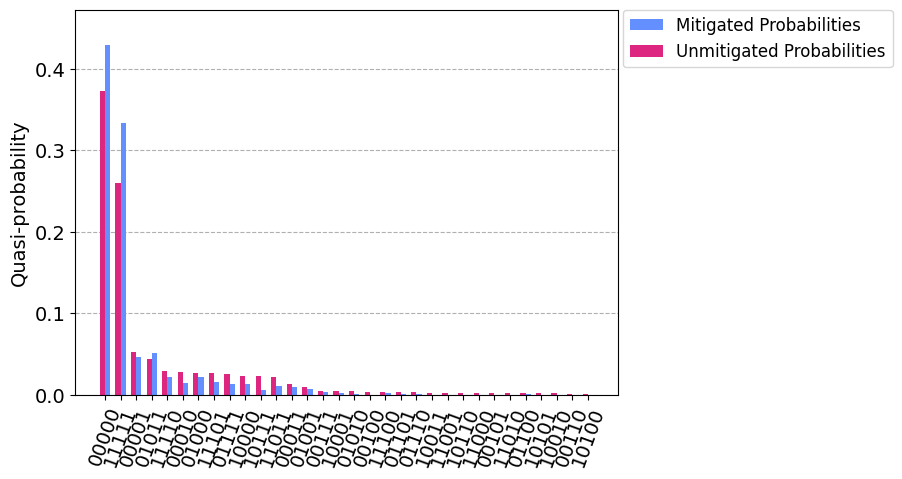

In [43]:
legend = ['Mitigated Probabilities', 'Unmitigated Probabilities']
plot_histogram([mitigated_probs, unmitigated_probs], legend=legend, sort="value_desc", bar_labels=False)

We can quickly see how the total success probability has increased by counting the number of all 0's and all 1's states. 

In [44]:
print((unmitigated_probs['00000']+unmitigated_probs['11111']))
print((mitigated_probs['00000']+mitigated_probs['11111']))

0.6326
0.7631892172441674


This is just 1 example of error mitigation for mitigating the "Local" (when you assume the readout erros for each qubit are independent) readout error. You could also apply what the Correlated readout error mitigation as described in Qiskit's tutorial or other forms of error mitigation which are described in [Mitiq's](https://mitiq.readthedocs.io/en/stable/guide/guide.html) documentation. 

## **Additional Reading**

- [Long-distance transmon coupler with CZ gate fidelity above 99.8%](https://arxiv.org/pdf/2208.09460.pdf). Paper by IQM describing the superconducting technology behind Helmi. 
- [Helmi press release](https://www.vttresearch.com/en/news-and-ideas/finlands-first-5-qubit-quantum-computer-now-operational). 
- [qiskit-on-iqm Github page](https://github.com/iqm-finland/qiskit-on-iqm).
- [qiskit-on-iqm documentation](https://iqm-finland.github.io/qiskit-on-iqm/). We are running `10.4`.
- [CSC documentation on Helmi](https://docs.csc.fi/computing/quantum-computing/overview/).
- [Pennylane-Qiskit documentation](https://docs.pennylane.ai/projects/qiskit/en/latest/).